## MRS fringes

The datafile contains one line of MIRI data, measured during the JWST integration tests. It contains, quite conspicuously, fringes on a changing background.

The goal of this example is to derive a model for the fringing.

Fringes are produced by accidental etalon(s) inside the instrument. In this case it seems that the detector itself is acting as etalon.


Demonstration: 
1. Etalon Model on a variable background (compound model)
2. Varying reflectance model (fixed model)
3. Evidence to find the best model.
4. Confidence region for the fit

Author: Do Kester


import classes

In [1]:
import numpy as numpy
import math

from astropy.io import ascii
from BayesicFitting import PolynomialModel
from BayesicFitting import EtalonModel
from BayesicFitting import SplinesModel
from BayesicFitting import SineModel
from BayesicFitting import LevenbergMarquardtFitter
from BayesicFitting import formatter as fmt

import matplotlib.pyplot as plt

# Initialize the Formatter to give better looking results 
from BayesicFitting import formatter_init as init
init( linelength=60, indent=13 )

Read the data. 
Transform wavelength (lamda in $\mu m$) in wavenumber in $mm^{-1}$. Subtract an arbitrary offset of 100.
Divide the fluxes by 100.
All to get 'nice' numbers.

In [2]:
tbl = ascii.read( "data/MRSdata.csv" )
lamda = tbl['col1'].data
flux = tbl['col2'].data
wgt = tbl['col3'].data
wnum = 1000.0 / lamda - 100
flux /= 100



Define the model as a SplinesModel for the background, multiplied by an EtalonModel for the fringes. We need to 'fix' the amplitude of the etalon. Otherwise the background and the amplitude are degenerate i.e. measure the same thing. 

In [3]:
mdl1 = SplinesModel( nrknots=10, xrange=wnum )
mdl1 *= EtalonModel( fixed={0:1.0} )
mdl1.parameters = [3.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,1.0,3.40,0.0]

print( mdl1 )


Splines of order 3 with 10 knots. *
Etalon: f( x:p ) = (1.0) / ( 1 + p_12 * sin^2( PI * x * p_13 + p_14 ) )


Define a non-linear fitter: LevenbergMarquardtFitter.

Fit the data to the model. Use weights as the data at the edge is less reliable as in the center.

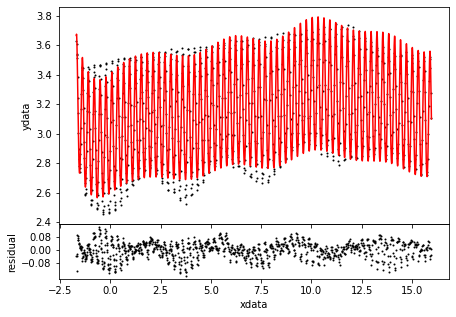

Parameters : [    3.407    0.118    0.032   -0.079    0.001
                  0.013   -0.019    0.022   -0.025    0.020
                 -0.016    0.029    0.312    3.413   -0.876]
StDevs     : [    0.004    0.007    0.003    0.005    0.002
                  0.001    0.001    0.001    0.001    0.001
                  0.002    0.005    0.001    0.000    0.003]
Scale      :     0.051
Evidence   :  1971.889


In [4]:
fitter = LevenbergMarquardtFitter( wnum, mdl1 )
 
#print( fitter.hessian )
# find the parameters
param = fitter.fit( flux, weights=wgt, plot=True )

print( "Parameters :", fmt( param, max=None ) )
print( "StDevs     :", fmt( fitter.stdevs, max=None ) )
print( "Scale      :", fmt( fitter.scale ) )
print( "Evidence   :", fmt( fitter.getEvidence( limits=[-10,10], noiseLimits=[0.01,10] ) ) )

 

The frequency of the etalon is OK, but the amplitude could be better. We know that the reflectance is slowly changing over the spectrum and it has a sinusiodal component. The finess is related to the reflectance as 
$f = 4 * R /( 1 + R^2 )$.

In this case we replace both the first and the second parameter by a model.

Etalon: f( x:p ) = (Splines) / ( 1 + (Polynomial + Sine) * sin^2( PI * x * p_0 + p_1 ) )


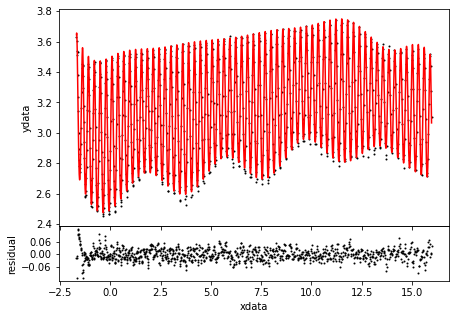

Parameters : [    3.413   -0.874    3.498    0.068    0.008
                 -0.053    0.008   -0.003    0.003   -0.003
                  0.004   -0.014    0.028   -0.054    0.356
                 -0.006    0.255    0.047   -0.013]
StDevs     : [    0.000    0.001    0.003    0.005    0.002
                  0.003    0.001    0.001    0.001    0.001
                  0.001    0.001    0.001    0.003    0.001
                  0.000    0.001    0.001    0.001]
Scale      :     0.027
Evidence   :  2768.876


In [5]:
finesse = PolynomialModel( 1 )
finesse += SineModel()

backgr = SplinesModel( nrknots=10, xrange=wnum )

mdl2 = EtalonModel( fixed={0:backgr, 1:finesse})

print( mdl2 )

pars = [3.4,0.0]                    # 2 remaining pars of Etalon
pars += [3.0] + [0.]*11             # 12 pars for backgr splines
pars += [1.0, 0.0, 0.25, 0.1, 0.0 ] # 5 pars for line + sine
mdl2.parameters = pars               # insert initial parameters

fitter = LevenbergMarquardtFitter( wnum, mdl2 )
param = fitter.fit( flux, weights=wgt, plot=True )

print( "Parameters :", fmt( param, max=None ) )
print( "StDevs     :", fmt( fitter.stdevs, max=None ) )
print( "Scale      :", fmt( fitter.scale ) )
print( "Evidence   :", fmt( fitter.getEvidence( limits=[-10,10], noiseLimits=[0.01,10] ) ) )


Obviously the last model is better than the first one.
The logEvidence increased by 646 - 389 = 257, which means that the odds of the last model to the first is

$P(\mbox{mdl2}) / P(\mbox{mdl1}) = 10^{257}$.

We want to try another model where the finesse is modeled as a SplinesModel. Maybe the waviness is not completely sinusoidal.

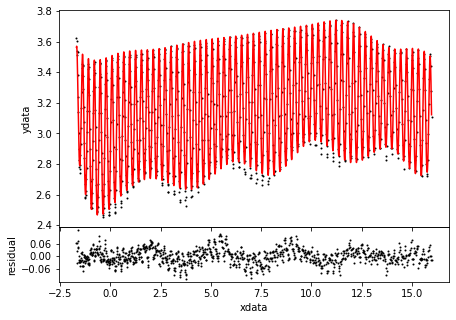

Parameters : [    3.413   -0.874    3.506    0.053   -0.001
                 -0.033    0.007   -0.004    0.002   -0.001
                  0.002   -0.010    0.020   -0.033    0.395
                 -0.060   -0.027    0.043    0.004   -0.013
                  0.016   -0.018    0.020   -0.023    0.027
                 -0.049]
StDevs     : [    0.000    0.002    0.004    0.008    0.003
                  0.006    0.002    0.001    0.001    0.001
                  0.001    0.001    0.002    0.006    0.003
                  0.005    0.002    0.004    0.001    0.001
                  0.001    0.001    0.001    0.001    0.001
                  0.004]
Scale      :     0.036
Evidence   :  2388.680


In [6]:
finesse = SplinesModel( nrknots=10, xrange=wnum )

backgr = SplinesModel( nrknots=10, xrange=wnum )

mdl = EtalonModel( fixed={0:backgr, 1:finesse})
pars = [3.4,0.0]                    # 2 remaining pars of Etalon
pars += [3.0] + [0.]*11             # 12 pars for backgr splines
pars += [0.35, -0.06] + [0.0] * 10  # 12 pars for finesse
mdl.parameters = pars               # insert initial parameters

fitter = LevenbergMarquardtFitter( wnum, mdl )
param = fitter.fit( flux, weights=wgt, plot=True )

print( "Parameters :", fmt( param, max=None ) )
print( "StDevs     :", fmt( fitter.stdevs, max=None ) )
print( "Scale      :", fmt( fitter.scale ) )
print( "Evidence   :", fmt( fitter.getEvidence( limits=[-10,10], noiseLimits=[0.01,10] ) ) )


From the residuals I would assume that the fit did not succeed completely. What exactly is wrong I dont know. Maybe the number of knots in the spline.

Anyway the logEvidence has gone down. So this model is not better than the previous one.